<h1> BrainStation Capstone Project</h1>

<b>Is the song "hot enough" for Billboard Hot100 🔥</b>
<br> Predicting the probability of a song reaching the Billboard Hot100 chart.</br>

Author: Hailey Lee
<br>Contact: ejlee.hailey@gmail.com
<br>Date: July 5, 2022

---

# Decision Trees

As a reminder, our problem statement is dealing with a classification problem: Will the song reach the billboard (1), or will it not (0). In this workbook, we will be using a machine learning algorithm called a Decision Tree. What is great about this model is that its thought process is similar to the way a human brain thinks:

For example:
- Question: Do I need to bring an umbrella? (yes or no)
    - Is it raining outside? Yes, then...
    - Do I have a raincoat? No, then...
    - Do I own an umbrella? Then yes!

The decision tree can also produce a flow chart along with scores like Gini Index and Feature Importance, so that we can visualize and understand the algorithm.

Note: We are not including the vectorized texts from song lyrics as features for this model. Text analysis is done in a separate Jupyter notebook for the sake of computation power and interpretability.

---
#### Table of Contents:
* [Score Summary](#scores)
* [Exploratory Data Analysis](#eda)
* Basic Modeling
    * [DecisionTree Model](#dtmodel1)
    * [DecisionTree Model with Cross Validation](#dtmodel2)
    * [DecisionTree Model Features](#dtfeat)
* Advanced Modeling
    * [Random Forest](#forest)
    * [Ada Boost](#ada)
* [Precision and Recall Scores](#precise)

### Score Summary<a class="anchor" id="scores"></a>

|Model | Parameters / Changes | Train Set Score | Test Set Score |
|:-----|:---------------------|:---------------:|:--------------:|
|Decision Tree | Default | 100.0% | 80.3% |
|Decision Tree with Cross Validation | max_depth=10 | 88.2% | 82.1% |
|Random Forest | Default | 100.0% | 87.1% |
|Random Forest with Cross Validation| max_depth=30, n_estimators=300 |100.0% | 87.6% |
|Random Forest Average Decision Tree| | 91.4% | 76.7% |
|Ada Boost | Default | 83.2% | 82.8% |
|Ada Boost Optimized | n_estimators=300 |85.3% | 83.9% |

### Quick Exploratory Data Analysis<a class="anchor" id="eda"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, plot_confusion_matrix, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
songs_df = pd.read_csv('capstone_dataset_clean.csv')

In [3]:
# column headers of our dataset
songs_df.columns

Index(['billboard', 'billboard_year', 'billboard_month', 'peak_position',
       'weeks_on_chart', 'artist', 'feat_artist', 'artist_uri',
       'artist_popularity', 'artist_followers', 'song', 'track_uri',
       'track_popularity', 'album_name', 'release_year', 'release_month',
       'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'major_label', 'genre_pop',
       'genre_screen', 'genre_hiphop', 'genre_punk', 'genre_blues',
       'genre_country', 'genre_rnb', 'genre_rock', 'genre_latin',
       'genre_dance', 'genre_indie', 'genre_elect', 'genre_gospel',
       'genre_chill'],
      dtype='object')

In [4]:
# quick look at our data
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13807 entries, 0 to 13806
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   billboard          13807 non-null  int64  
 1   billboard_year     13807 non-null  int64  
 2   billboard_month    13807 non-null  int64  
 3   peak_position      13807 non-null  int64  
 4   weeks_on_chart     13807 non-null  int64  
 5   artist             13807 non-null  object 
 6   feat_artist        13807 non-null  object 
 7   artist_uri         13807 non-null  object 
 8   artist_popularity  13807 non-null  int64  
 9   artist_followers   13807 non-null  int64  
 10  song               13807 non-null  object 
 11  track_uri          13807 non-null  object 
 12  track_popularity   13807 non-null  int64  
 13  album_name         13807 non-null  object 
 14  release_year       13807 non-null  int64  
 15  release_month      13807 non-null  int64  
 16  duration_ms        138

We will need to drop the columns that are not numeric and Billboard-exclusive for this model.

In [5]:
print(f'Number of rows: {songs_df.shape[0]}')
print(f'Number of columns: {songs_df.shape[1]}')
print(f'Number of null values: {songs_df.isna().sum().sum()}')
print(f'Number of duplicates: {songs_df.duplicated().sum()}')

Number of rows: 13807
Number of columns: 44
Number of null values: 0
Number of duplicates: 0


Data is clean and ready to go.

---
### Decision Tree Model<a class="anchor" id="dtmodel1"></a>

To start, we will assign our target variable and features.

In [6]:
# assign target variables and features without Billboard exclusive stats
y = songs_df['billboard']
X = songs_df.drop(columns=['billboard','billboard_year', 'billboard_month', 'peak_position', 'weeks_on_chart',
                          'artist', 'feat_artist', 'artist_uri', 'song', 'track_uri', 'album_name'])

# 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    random_state = 15)

In [7]:
print(f'X_train has {X_train.shape[0]} rows and {X_train.shape[1]} columns.')
print(f'y_train has {y_train.shape[0]} rows and 1 column.')
print(f'X_test has {X_test.shape[0]} rows and {X_test.shape[1]} columns.')
print(f'y_test has {y_test.shape[0]} rows and 1 column.')

X_train has 10355 rows and 33 columns.
y_train has 10355 rows and 1 column.
X_test has 3452 rows and 33 columns.
y_test has 3452 rows and 1 column.


We will run a vanilla Decision Tree model with default parameters to serve as our baseline.

In [8]:
# instantiate model
DT_model = DecisionTreeClassifier(random_state=15) 

# fit on train set
DT_model.fit(X_train, y_train)

# score on both sets
print(f'Train set accuracy: {round(DT_model.score(X_train, y_train)*100,1)}%')
print(f'Test set accuracy: {round(DT_model.score(X_test, y_test)*100,1)}%')

Train set accuracy: 100.0%
Test set accuracy: 80.3%


If we do not set the `max_depth` hyperparameter in Decision Trees, the model will keep growing branches until every data is classified perfectly. While this is great for our train set accuracy, it may not be as great when new information (test set) is introduced to the model.

In the following cell, we will record our train and test codes based on a range of values for `max_depth`:

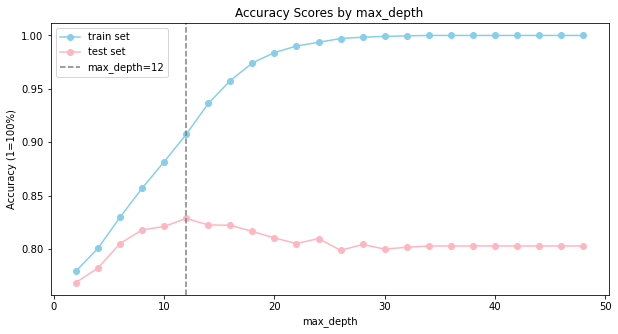

In [15]:
depth = np.arange(2,50,2)

train_score = []
test_score = []

# run the model with each max_depth
for i in depth:
    DT_model = DecisionTreeClassifier(max_depth=i, random_state=15)
    DT_model.fit(X_train, y_train)
    train_score.append(DT_model.score(X_train, y_train))
    test_score.append(DT_model.score(X_test, y_test))
    
#visualize
plt.figure(figsize=(10,5))
plt.plot(depth, train_score, label='train set', marker='o', color='skyblue')
plt.plot(depth, test_score, label='test set', marker='o', color='lightpink')
plt.axvline(12,linestyle='--', color='grey', label='max_depth=12')
plt.title('Accuracy Scores by max_depth')
plt.ylabel('Accuracy (1=100%)')
plt.xlabel('max_depth')
plt.legend()
plt.show()

In [16]:
DT_model = DecisionTreeClassifier(max_depth=12,
                                  random_state=15) 

DT_model.fit(X_train, y_train)
print(f'Train set accuracy: {round(DT_model.score(X_train, y_train)*100,1)}%')
print(f'Test set accuracy: {round(DT_model.score(X_test, y_test)*100,1)}%')

Train set accuracy: 90.7%
Test set accuracy: 82.9%


Based on the graph above, the optimal point for best test score while minimizing any overfitting is at `max_depth = 12`. And when we plug in that parameter, our test set accuracy improves!

### Decision Tree Model with Cross Validation<a class="anchor" id="dtmodel2"></a>

But there is a problem -- there is bias in this approach. The test set represents future, unseen data in the real world, which means that data will not be readily available for us to set the parameters of our model. We have knowingly chosen a parameter that would generate a high test score. 

To address this, there is a process called cross-validation. Essentially, we will split our train set to "train" and "validation" sets in order to set our hyperparameter. Moreover, we will use the K-fold Cross Validation method which will create validation sets in $k$ number of folds of our train set and calculate the average of the CV scores.

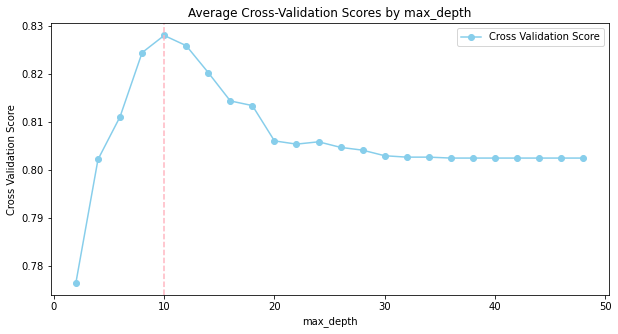

In [17]:
# store the results
cv_scores = []

# test max_depth of 2 to 50
max_depth = np.arange(2,50,2)

for depth in max_depth:
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=15)
    
    # mean of cross validation scores from all folds
    cv_score = np.mean(cross_val_score(DT_model, X_train, y_train, cv = 5))
    
    cv_scores.append(cv_score)

plt.figure(figsize=(10,5))
plt.plot(max_depth, cv_scores,label='Cross Validation Score', marker='o', color='skyblue')
plt.axvline(10,linestyle='--', color='lightpink')
plt.xlabel('max_depth')
plt.ylabel('Cross Validation Score')
plt.title('Average Cross-Validation Scores by max_depth')
plt.legend()
plt.show()

In [18]:
# re-run with new parameter
DT_model = DecisionTreeClassifier(max_depth=10,
                                  random_state=15)

# fit on train set
DT_model.fit(X_train, y_train)

# score on both sets
print(f'Train set accuracy: {round(DT_model.score(X_train, y_train)*100,1)}%')
print(f'Test set accuracy: {round(DT_model.score(X_test, y_test)*100,1)}%')

Train set accuracy: 88.2%
Test set accuracy: 82.1%


We produced slightly different results this time. After cross validating, `max_depth=10` actually produced the highest average cross validation score. While our test score dropped, we are more confident with this approach as there is no data leakage (i.e. the model was exposed to the test data).

### Decision Tree Features<a class="anchor" id="dtfeat"></a>

In [19]:
print(f'As a reminder, our Decision Tree model is looking at {X_train.shape[1]} features.')

As a reminder, our Decision Tree model is looking at 33 features.


That's a lot of features to look at just to make a binary classification of a data point. Unlike other models, the Decision Tree goes from macro to micro (as each node looks at a smaller subset of data each time), and at each node, the model makes a decision that best minimizes the confusion that the model has about the data. This is why they are called *greedy classifiers*. 

Take a look at the tree plot below (you may need to zoom in):

The first node, also called the *decision stump*, decided that `track_popularity` gave the best 50/50 split of our data. We can verify this by looking at the [gini index](https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb) of 0.5. The gini index looks at the class distribution of a given feature and measures of how wrong a random data point would be mis-classified. Our model continues this process until a given `max_depth` and splits each subset of data based on which feature would give the best split.

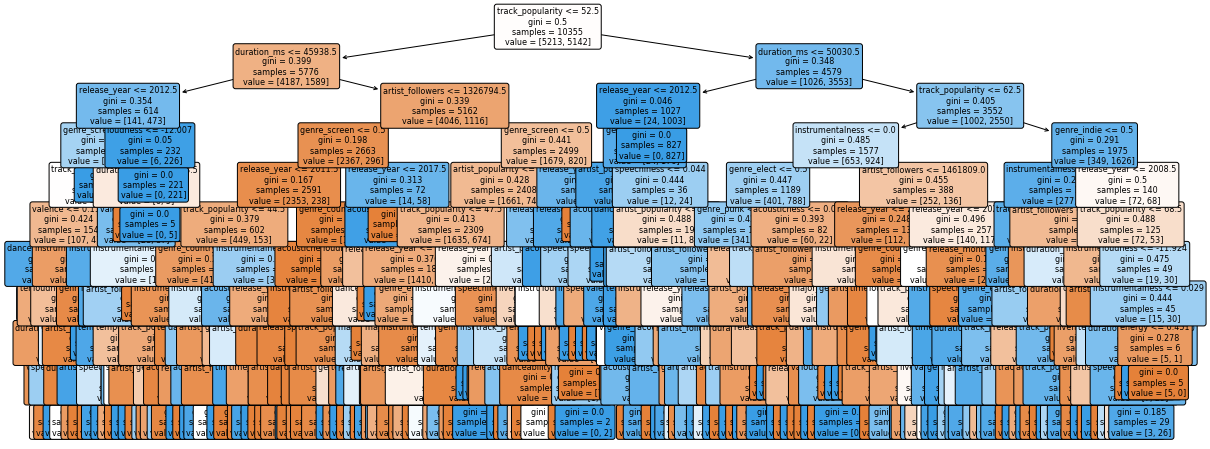

In [20]:
# visualize the decision tree model
fig, ax = plt.subplots(figsize=(20,8))

plot_tree(DT_model,
          feature_names=X_train.columns,
          rounded=True,
          impurity=True,
          filled=True,
          ax=ax,
          fontsize=8)

plt.show()

Now that we understand a little more about the model's algorithm, let's take a closer look at the features and understand why the model certain features for its splits. There are two ways to look at this: *Feature Importance* and *Permutation Importance*.

#### Feature Importance

Technically speaking, [feature importance](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3#:~:text=Feature%20importance%20is%20calculated%20as,the%20more%20important%20the%20feature) is "the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature." Simply put, it is a score that measures how important the feature is to the model and what impact it makes.

Let's visualize the top 20 features that were considered important based on Feature Importance score. 

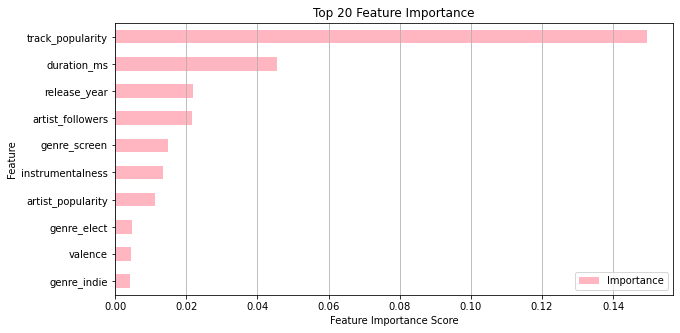

In [41]:
# call the .compute_feature_importances attribute and put data in dataframe
pd.DataFrame({'Feature': X_train.columns,
              'Importance': DT_model.tree_.compute_feature_importances(normalize=False)})\
.sort_values(by='Importance', ascending=False).head(10).plot(kind='barh',
                                                            figsize=(10,5),
                                                            x='Feature',
                                                            title='Top 20 Feature Importance',
                                                            color='lightpink')
plt.xlabel('Feature Importance Score')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

In [42]:
# see the importance scores
pd.DataFrame({'Feature': X_train.columns,
              'Importance': DT_model.tree_.compute_feature_importances(normalize=False)}).sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
2,track_popularity,0.149359
5,duration_ms,0.045428
3,release_year,0.022013
1,artist_followers,0.021625
20,genre_screen,0.014862
13,instrumentalness,0.013592
0,artist_popularity,0.011179
30,genre_elect,0.004737
15,valence,0.004540
29,genre_indie,0.004202


By far, `track_popularity` was considered most important to the model. As a reminder, a track's popularity is a score given by Spotify, and just like what we saw in the Logistic Regression coefficients, what Spotify considers popular and what Billboard considers popular are aligned.

Moreover, like the Logistic Regression model which had strong negative coefficients for `release_year` and `duration_ms`, the Decision Tree model also found these features to be important decision makers. However, unlike the Logistic Regression model, the Decision Tree model fails to give us the +/- *direction* of these features.

#### Permutation Importance

The caveat with Feature importance is that the measures are impurity-based (gini index) which causes biased towards features with high cardinality, that is, the number of different elements within a feature. 

To address this, we have another scoring system called [Permutation Importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html). This measure is slightly different as it calculates the loss function of a certain feature if it were shuffled `n_repeats` times while all other target variable and features remain in place. The higher the loss (in accuracy) due to the shuffled feature, the higher its importance.

For the remainder of our workbook, we will be using Permutation Importance.

In [22]:
# store permutation importance scores into variable
result = permutation_importance(DT_model, X_train, y_train,
                                n_repeats=100,    # shuffle 100 times (default=5)
                                random_state=15)

# calculate the average importance per feature
avg_importance = result.importances_mean

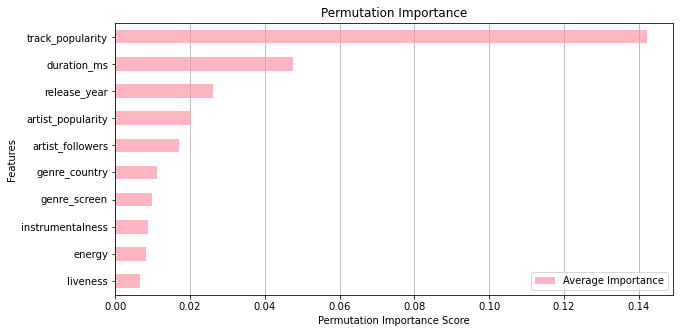

In [43]:
# visualize top 10 results
pd.DataFrame({'Features': X_train.columns,
              'Average Importance': avg_importance}).sort_values(by='Average Importance', ascending=False).head(10)\
.plot(kind='barh',
      figsize=(10,5),
      x='Features',
      title='Permutation Importance',
     color='lightpink')

plt.xlabel('Permutation Importance Score')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

In [45]:
# see the average scores
pd.DataFrame({'Features': X_train.columns,
              'Average Importance': avg_importance}).sort_values(by='Average Importance', ascending=False).head(10)

,Features,Average Importance
2,track_popularity,0.142038
5,duration_ms,0.047446
3,release_year,0.026277
0,artist_popularity,0.019913
1,artist_followers,0.017132
24,genre_country,0.011106
20,genre_screen,0.009908
13,instrumentalness,0.008691
7,energy,0.008296
14,liveness,0.006606


The results are similar, but we know that the second model has less bias. Here's a quick feature-to-feature comparison:

|Importance Rank | Feature Importance | Permutation Importance | Match? |
|:--------------:|:-------------------|:-----------------------|:------:|
|1. | track_popularity | track_popularity | ✅
|2. | duration_ms | duration_ms | ✅
|3. | release_year | release_year | ✅
|4. | artist_followers | artist_followers | ✅
|5. | genre_screen | artist_popularity | ❌
|6. | instrumentalness | instrumentalness | ✅
|7. | artist_popularity | genre_screen | ❌
|8. | genre_elect | genre_country | ❌
|9. | valence | genre_elect | ❌
|10. | genre_indie | major_label | ❌

---
### Random Forest Model<a class="anchor" id="forest"></a>

As we can tell by now, Decision Trees can tend to be very biased and they are sensitive to minor changes in the data. For example, we split our data to train and test models with a 75/25 ratio and random_state at 15. What if we took the same ratio but made a different split (different random state)? The Decision Tree is now introduced to a different subset of data. A workaround for this is called [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier which trains on `n_estimators` number of Decision Trees and then averages the results of each one. 

In [9]:
# instantiate
random_forest = RandomForestClassifier(random_state=15) # default n_estimators = 100

# fit to train set
random_forest.fit(X_train, y_train)

# score on both sets
print(f'Train set accuracy: {round(random_forest.score(X_train, y_train)*100,1)}%')
print(f'Test set accuracy: {round(random_forest.score(X_test, y_test)*100,1)}%')

Train set accuracy: 100.0%
Test set accuracy: 87.1%


This is a great score, but we are still seeing some overfitting. We can also set a limit on the `max_depth` (just as we did for a single Decision Tree) and run it through a GridSearch for our optimal parameters.

In [25]:
# set up pipeline
pipe = Pipeline([('model', RandomForestClassifier(random_state=15))])

# set up GridSearch parameters
param_grid = [{
    'model__n_estimators': [50,100,150,200,300],  # we'll test out different number of trees as well
    'model__max_depth':[2, 10, 15, 20, 25, 30, 50]
}]

# set up gridsearch cross validation
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2)

# fit train set
fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] END .........model__max_depth=2, model__n_estimators=50; total time=   0.4s
[CV] END .........model__max_depth=2, model__n_estimators=50; total time=   0.4s
[CV] END .........model__max_depth=2, model__n_estimators=50; total time=   0.4s
[CV] END .........model__max_depth=2, model__n_estimators=50; total time=   0.4s
[CV] END .........model__max_depth=2, model__n_estimators=50; total time=   0.3s
[CV] END ........model__max_depth=2, model__n_estimators=100; total time=   0.9s
[CV] END ........model__max_depth=2, model__n_estimators=100; total time=   0.8s
[CV] END ........model__max_depth=2, model__n_estimators=100; total time=   0.8s
[CV] END ........model__max_depth=2, model__n_estimators=100; total time=   1.1s
[CV] END ........model__max_depth=2, model__n_estimators=100; total time=   1.0s
[CV] END ........model__max_depth=2, model__n_estimators=150; total time=   1.4s
[CV] END ........model__max_depth=2, model__n_e

[CV] END ........model__max_depth=25, model__n_estimators=50; total time=   1.1s
[CV] END ........model__max_depth=25, model__n_estimators=50; total time=   1.4s
[CV] END ........model__max_depth=25, model__n_estimators=50; total time=   1.4s
[CV] END ........model__max_depth=25, model__n_estimators=50; total time=   1.3s
[CV] END .......model__max_depth=25, model__n_estimators=100; total time=   2.8s
[CV] END .......model__max_depth=25, model__n_estimators=100; total time=   3.0s
[CV] END .......model__max_depth=25, model__n_estimators=100; total time=   3.8s
[CV] END .......model__max_depth=25, model__n_estimators=100; total time=   2.7s
[CV] END .......model__max_depth=25, model__n_estimators=100; total time=   2.7s
[CV] END .......model__max_depth=25, model__n_estimators=150; total time=   4.0s
[CV] END .......model__max_depth=25, model__n_estimators=150; total time=   4.3s
[CV] END .......model__max_depth=25, model__n_estimators=150; total time=   4.2s
[CV] END .......model__max_d

In [28]:
fittedgrid.best_params_

{'model__max_depth': 30, 'model__n_estimators': 300}

In [10]:
# instantiate
random_forest = RandomForestClassifier(max_depth=30,
                                      n_estimators=300,
                                      random_state=15)

# fit to train set
random_forest.fit(X_train, y_train)

# score on both sets
print(f'Train set accuracy: {round(random_forest.score(X_train, y_train)*100,2)}%')
print(f'Test set accuracy: {round(random_forest.score(X_test, y_test)*100,2)}%')

Train set accuracy: 100.0%
Test set accuracy: 87.6%


Our accuracy improved slightly, albeit it appears like there is some "overfitting" still. This [article](https://towardsdatascience.com/one-common-misconception-about-random-forest-and-overfitting-47cae2e2c23b) discusses the phenomenon. Random forests work in a way that aggregates results from individual trees and uses a process called voting to make the predictions. So while the train accuracy score is 100%, we still have really great results from our test set. We will move forward with this model.

When running Random Forests, it is also important to look at the average score of each of the decision tree within the random forest as it differs from the overall random forest accuracy score.

In [29]:
train_scores = []

for tree in random_forest.estimators_:
    train_scores.append(tree.score(X_train, y_train))
    
print("Accuracy on train set:")
print(f"Average Decision Tree: {np.mean(train_scores)}")
print(f"Random Forest: {random_forest.score(X_train, y_train)}")
print('--------------------------------------------')

test_scores = []

for tree in random_forest.estimators_:
    test_scores.append(tree.score(X_test, y_test))
    
print("Accuracy on test set:")
print(f"Average Decision Tree: {np.mean(test_scores)}")
print(f"Random Forest: {random_forest.score(X_test, y_test)}")

Accuracy on train set:
Average Decision Tree: 0.9145643006599066
Random Forest: 1.0
--------------------------------------------
Accuracy on test set:
Average Decision Tree: 0.7663460795674005
Random Forest: 0.8760139049826188


We can see that the Random Forest scores are better than an average tree as Random Forest aggregates the results of an ensemble of decision trees which were created with a subset of the data.

#### Permutation Importance

In [11]:
# store permutation importance scores into variable
result = permutation_importance(random_forest, X_train, y_train,
                                n_repeats=10,
                                random_state=15)

# calculate the average importance per feature
avg_importance = result.importances_mean

In [12]:
import plotly.express as px

In [19]:
perm = pd.DataFrame({'Features': X_train.columns,
              'Average Importance': avg_importance}).sort_values(by='Average Importance', ascending=True).tail(5)

In [22]:
fig = px.bar(data_frame=perm,
                 x='Average Importance',
                 y='Features',
                 title='Random Forest: Permutation Importance',
             color_discrete_sequence=px.colors.qualitative.Dark2,
            orientation='h')

fig.update_layout(plot_bgcolor = 'rgba(0, 0, 0, 0)' )

fig.update_xaxes(linewidth = 1, linecolor ='black')
fig.update_yaxes(linewidth = 1, linecolor ='black')
fig.show()

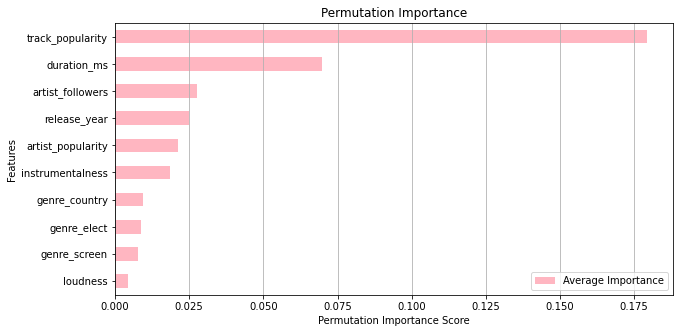

In [47]:
# visualize top 20 results
pd.DataFrame({'Features': X_train.columns,
              'Average Importance': avg_importance}).sort_values(by='Average Importance', ascending=False).head(10)\
.plot(kind='barh',
      figsize=(10,5),
      x='Features',
      title='Permutation Importance',
      color='lightpink')

plt.xlabel('Permutation Importance Score')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

In [48]:
# see the avg scores
pd.DataFrame({'Features': X_train.columns,
              'Average Importance': avg_importance}).sort_values(by='Average Importance', ascending=False).head(10)

,Features,Average Importance
2,track_popularity,0.179189
5,duration_ms,0.069841
1,artist_followers,0.027668
3,release_year,0.024983
0,artist_popularity,0.021236
13,instrumentalness,0.018416
24,genre_country,0.009396
30,genre_elect,0.008769
20,genre_screen,0.007793
9,loudness,0.004211


It looks like the permutation importance scores of a single tree and a random forest are generally similar except for a few swaps. In both lists, the features `track_popularity` and `duration_ms` have been consistently considered important to the model's algorithm for classifying songs on the Billboard.

|Importance Rank | Decision Tree | Random Forest | Match? |
|:--------------:|:-------------------|:-----------------------|:------:|
|1. | track_popularity | track_popularity | ✅
|2. | duration_ms | duration_ms | ✅
|3. | release_year | artist_followers | ❌
|4. | artist_followers | release_year | ❌
|5. | artist_popularity | artist_popularity | ✅
|6. | instrumentalness | instrumentalness | ✅
|7. | genre_screen | genre_country |❌
|8. | genre_country | genre_elect |❌
|9. | genre_elect | genre_screen | ❌
|10.| major_label | loudness |❌

---
### Ada Boost<a class="anchor" id="ada"></a>

The [Ada Boost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) classifier is another method for reducing bias in decision trees. This booster fits `n_estimators` of weak models (i.e. Decision Tree models with `max_depth=1`), wherein each time the model tries to improve on where the previous model predicted incorrectly (ignoring what the previous model got right). In the end, Ada Boost averages out the models but re-weighs model's contribution based on their accuracy. 

In [31]:
# instantiate
ada_boost = AdaBoostClassifier(random_state=15)  # default is n_estimators = 50

# fit on train set
ada_boost.fit(X_train, y_train)

# score both on train and test sets
print(f'Train set accuracy: {round(ada_boost.score(X_train, y_train)*100,1)}%')
print(f'Test set accuracy: {round(ada_boost.score(X_test, y_test)*100,1)}%')

Train set accuracy: 83.2%
Test set accuracy: 82.8%


In [32]:
# set up pipeline
pipe = Pipeline([('model', AdaBoostClassifier(random_state=15))])

# set up GridSearch parameters
param_grid = [{
    'model__n_estimators': [25,50,100,200,300,500],
    'model__learning_rate':[0.0, 0.5, 1.0, 1.5, 2.0]
}]

# set up gridsearch cross validation
grid = GridSearchCV(pipe, param_grid, cv=5)

# fit train set
fittedgrid = grid.fit(X_train, y_train)

In [33]:
# best estimator object
fittedgrid.best_estimator_

Pipeline(steps=[('model',
                 AdaBoostClassifier(n_estimators=300, random_state=15))])

In [34]:
# see parameters
fittedgrid.best_params_

{'model__learning_rate': 1.0, 'model__n_estimators': 300}

In [36]:
# update our model
ada_boost = AdaBoostClassifier(n_estimators=300,
                               random_state=15)

# fit on train set
ada_boost.fit(X_train, y_train)

# score both on train and test sets
print(f'Train set accuracy: {round(ada_boost.score(X_train, y_train)*100,1)}%')
print(f'Test set accuracy: {round(ada_boost.score(X_test, y_test)*100,1)}%')

Train set accuracy: 85.3%
Test set accuracy: 83.9%


This best model gave us an improved score of 83.9% test accuracy!

#### Permutation Importance

In [49]:
# store permutation importance scores into variable
result = permutation_importance(ada_boost, X_train, y_train,
                                n_repeats=10,
                                random_state=15)

# calculate the average importance per feature
avg_importance = result.importances_mean

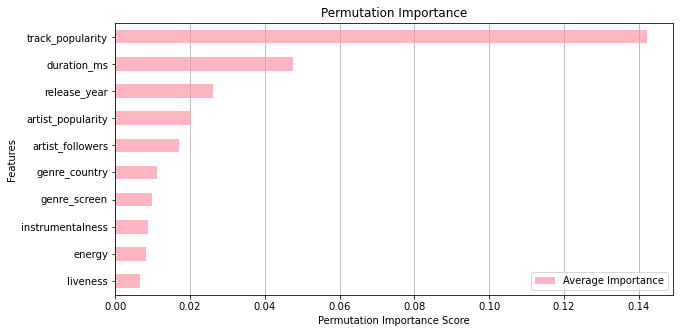

In [50]:
# visualize top 10 results
pd.DataFrame({'Features': X_train.columns,
              'Average Importance': avg_importance}).sort_values(by='Average Importance', ascending=False).head(10)\
.plot(kind='barh',
      figsize=(10,5),
      x='Features',
      title='Permutation Importance',
      color='lightpink')

plt.xlabel('Permutation Importance Score')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

In [51]:
# see the avg scores
pd.DataFrame({'Features': X_train.columns,
              'Average Importance': avg_importance}).sort_values(by='Average Importance', ascending=False).head(10)

,Features,Average Importance
2,track_popularity,0.142038
5,duration_ms,0.047446
3,release_year,0.026277
0,artist_popularity,0.019913
1,artist_followers,0.017132
24,genre_country,0.011106
20,genre_screen,0.009908
13,instrumentalness,0.008691
7,energy,0.008296
14,liveness,0.006606


Here is a compiled comparison of our tree models' top ten features by permutation importance. Without a doubt, `track_popularity` and `duration_ms` have been consistently an important feature for our tree models, that is, every time these features were shuffled, we had a greater loss in our accuracy scores.


|Importance Rank | Decision Tree | Random Forest | Ada Boost | Match? |
|:--------------:|:--------------|:--------------|:----------|:------:|
|1. | track_popularity | track_popularity | track_popularity | ✅
|2. | duration_ms | duration_ms | duration_ms | ✅
|3. | release_year | artist_followers | release_year | ❌
|4. | artist_followers | release_year | artist_popularity | ❌
|5. | artist_popularity | artist_popularity | artist_followers | ❌
|6. | instrumentalness | instrumentalness | genre_country |❌
|7. | genre_screen | genre_country | genre_screen |❌
|8. | genre_country | genre_elect | instrumentalness | ❌
|9. | genre_elect | genre_screen | energy | ❌
|10.| major_label | loudness | liveness |❌

---
### How precise are our models?<a class="anchor" id="precise"></a>

In [52]:
y_pred = DT_model.predict(X_test)
print(f'Decision Tree Model:')
print(f'Precision Score: {round(precision_score(y_test, y_pred)*100,1)}%')
print(f'Recall Score: {round(recall_score(y_test, y_pred)*100,1)}%')
print(f'F1 Score: {round(f1_score(y_test, y_pred)*100,1)}%')
print('------------------------------------')
y_pred = random_forest.predict(X_test)
print(f'Random Forest Model:')
print(f'Precision Score: {round(precision_score(y_test, y_pred)*100,1)}%')
print(f'Recall Score: {round(recall_score(y_test, y_pred)*100,1)}%')
print(f'F1 Score: {round(f1_score(y_test, y_pred)*100,1)}%')
print('------------------------------------')
y_pred = ada_boost.predict(X_test)
print(f'Ada Boost Model:')
print(f'Precision Score: {round(precision_score(y_test, y_pred)*100,1)}%')
print(f'Recall Score: {round(recall_score(y_test, y_pred)*100,1)}%')
print(f'F1 Score: {round(f1_score(y_test, y_pred)*100,1)}%')

Decision Tree Model:
Precision Score: 82.0%
Recall Score: 81.0%
F1 Score: 81.5%
------------------------------------
Random Forest Model:
Precision Score: 87.2%
Recall Score: 87.2%
F1 Score: 87.2%
------------------------------------
Ada Boost Model:
Precision Score: 83.8%
Recall Score: 82.9%
F1 Score: 83.3%


We have class balance in our dataset so these scores are supplementary. The F1 scores (combination of Precision and Recall) are similar to our overall accuracy scores, so there are no red flags here.

---

<center>2022 BrainStation Capstone Project
    <br>"Is the song <i>hot enough</i> for Billboard Hot100?"
    <br>by Hailey Lee</center>